In [1]:
%matplotlib inline
import torch
import json
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from Data_Loader import Pose_Dataset, my_collate, RandomFlip, RandomRotate, ToTensor
from torchvision import transforms, utils

In [2]:
dataset = Pose_Dataset(annotations_path = '../annotations/vru_keypoints_val_copy.json',
                      img_path = '../images/val',
                      transform = transforms.Compose([
                          RandomFlip(0.5),
                          RandomRotate(degree = 10),
#                           ToTensor()
                      ]))

(269, 117)


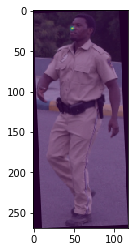

In [3]:
sample = dataset[1]
print(sample['target'][3][:, :, 0].shape)
plt.imshow(sample['target'][3][:, :, 0])
plt.imshow(sample['image'][:, :, [2, 1, 0]], alpha = 0.5)